<a href="https://colab.research.google.com/github/naimurborno/Object-Detection-using-api/blob/main/object%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageColor

In [3]:
module="https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
module=hub.load(module)
detector=module.signatures['default']

In [19]:
def draw_image_on_bounding_box(image,ymin,xmin,ymax,xmax,color,font,display_img_str=(),thickness=4):
  draw=ImageDraw.Draw(image)
  im_width,im_hight=image.size
  (left,right,top,bottom)=(xmin*im_width,xmax*im_width,ymin*im_hight,ymax*im_hight)
  draw.line([(left,top),(left,bottom),(right,bottom),(right,top),(left,top)],width=thickness,fill=color)

  display_str_hight=[font.getsize(ds)[1] for ds in display_img_str]
  total_display_str_hight=(1+2*0.05)*sum(display_str_hight)
  if top>total_display_str_hight:
    text_bottom=top
  else:
    text_bottom=top+total_display_str_hight
  for display_str in display_img_str[::-1]:
    text_hight,text_width=font.getsize(display_str)
    margin=np.ceil(0.05*text_hight)
    draw.rectangle([(left,text_bottom-text_hight-2*margin),(left+text_width,text_bottom)],fill=color)
    draw.text((left+margin,text_bottom-text_hight-margin),display_str,fill='Black',font=font)
    text_bottom-=text_hight-2*margin

def draw_bounding_box(image,box,class_name,score,max_box=10,min_score=0.1):
  colors=list(ImageColor.colormap.values())
  font=ImageFont.load_default()
  for i in range(min(box.shape[0],max_box)):
    if score[i]>=0.1:
      ymin,xmin,ymax,xmax=tuple(box[i])
      display_str="{}:{}%".format(class_name[i].decode("ascii"),int(score[i]*100))
      color=colors[hash(class_name[i])%len(colors)]
      image_pil=Image.fromarray(np.uint8(image)).convert("RGB")
      draw_image_on_bounding_box(image_pil,ymin,xmin,ymax,xmax,color,font,display_img_str=[display_str])
      np.copyto(image,np.array(image_pil))
  return image

In [6]:
from google.colab import files
import cv2


In [ ]:
files.upload()

In [45]:
image_file=cv2.imread('/content/WhatsApp Image 2023-07-21 at 15.25.03.jpeg')
image_file=cv2.cvtColor(image_file,cv2.COLOR_BGR2RGB)

In [46]:
imge_file_in_tensor=tf.convert_to_tensor(image_file)

In [47]:
converted_image=tf.image.convert_image_dtype(imge_file_in_tensor,tf.float32)[tf.newaxis,...]

In [48]:
result=detector(converted_image)

In [49]:
result_log={key:value.numpy() for key,value in result.items()}

In [50]:
result_log.keys()

dict_keys(['detection_class_labels', 'detection_class_names', 'detection_class_entities', 'detection_boxes', 'detection_scores'])

In [51]:
image_with_bounding_box=draw_bounding_box(image_file,result_log['detection_boxes'],result_log['detection_class_entities'],result['detection_scores'])

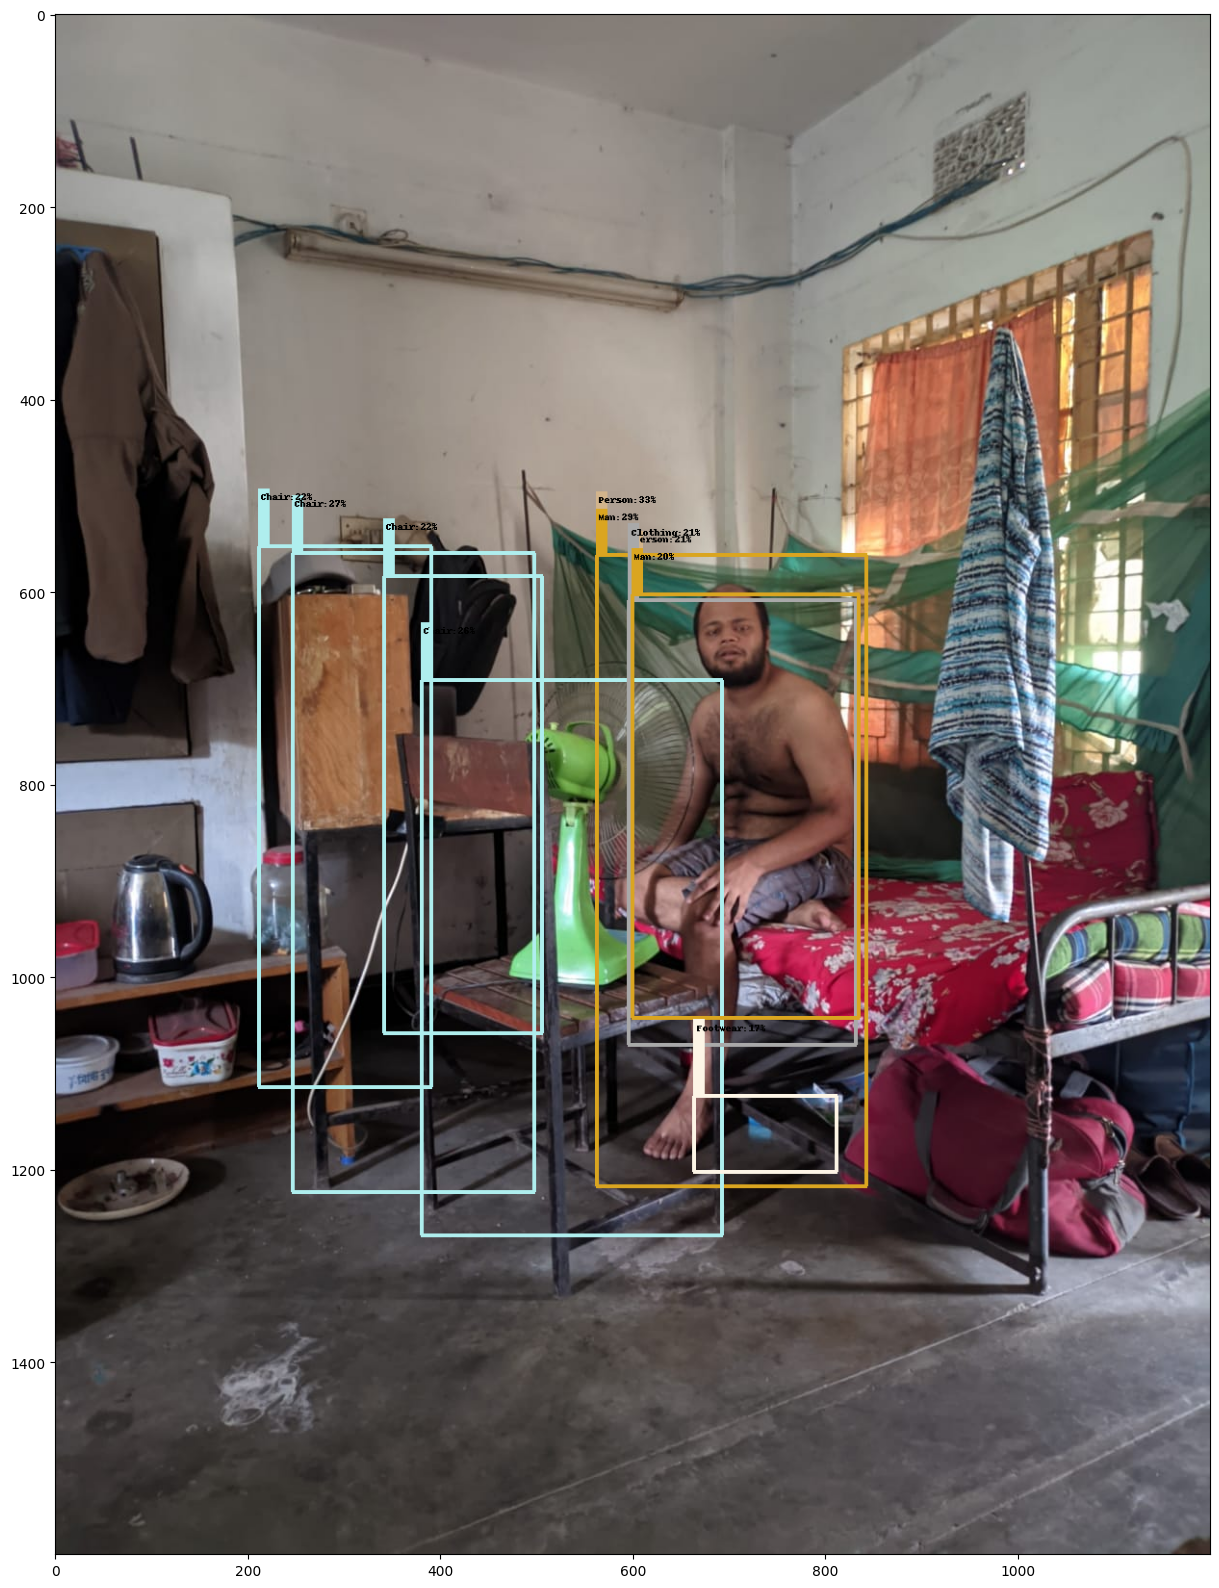

In [52]:
from google.colab.patches import cv2_imshow
plt.figure(figsize=(20,20))
plt.imshow(image_with_bounding_box)